### Predict Future Sales

This is a time-series regression-based project for the Kaggle competition 'Predict Future Sales'. The task is to predict sales for the month of November for a series of shop-item pairs, based on past sales.

Due to the size of the dataset, I performed this project on Google Colab Pro +. I had initially used Kaggle, but ran into frequent problems with a lack of RAM when performing manipulations on the dataset. Using Google Colab Pro + I was able to make use of the high-RAM CPU setting for the data preprocessing, before switching to the GPU for the modelling.

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pip install datatable

In [ ]:
# Import necessary libaries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gc
from sklearn.preprocessing import OneHotEncoder
import datatable as dt
from datetime import date, timedelta
from itertools import product

In [ ]:
# Read the separate files into dataframes

item_categories = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/item_categories.csv")
items = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/items.csv")
sales = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sales_train.csv")
shops = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/shops.csv")

In [ ]:
# View each dataframe to get an overview of the data

sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [ ]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [ ]:
# Let's also read in the test data so we can see what that consists of

test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv")
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


### Exploratory Data Analysis

The `test` dataframe confirms the competition brief; the target to predict is the number of each item sold by each shop **in one month**.

The `sales` dataframe clearly shows that the training set consists of **daily sales**, so I will likely need to do some aggregating at some point.

There are several text fields across the dataframes. However, given that these text fields appear to be written in Russian, I don't intend to use them at this time. This could be something to explore later to try to improve my results. Given that the only non-text data in the `item_categories` and `shops` dataframes are replicated elsewhere, I will delete these now to save memory.

I will then move on to some exploratory data analysis to get a better picture of the data.

In [ ]:
del item_categories
del shops
gc.collect()

188

In [ ]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [ ]:
items.describe()

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


In [ ]:
print("Number of sales records in training set:",len(sales))
print("Number of distinct items in training set:",len(items["item_id"].unique()))
print("Number of distinct item categories in training set:",len(items["item_category_id"].unique()))
print("Number of distinct shops in training set:",len(sales['shop_id'].unique()))

Number of sales records in training set: 2935849
Number of distinct items in training set: 22170
Number of distinct item categories in training set: 84
Number of distinct shops in training set: 60


There are no missing values in any of the dataframes. There are almost 3 million sales records in the training data. There are 22,170 distinct product IDs, spanning 84 distinct product categories. Additionally, there are 60 different shops.

In [ ]:
test.describe()

,ID,shop_id,item_id
count,214200.000000,214200.000000,214200.000000
mean,107099.500000,31.642857,11019.398627
std,61834.358168,17.561933,6252.644590
min,0.000000,2.000000,30.000000
25%,53549.750000,16.000000,5381.500000
50%,107099.500000,34.500000,11203.000000
75%,160649.250000,47.000000,16071.500000
max,214199.000000,59.000000,22167.000000


In [ ]:
print("Number of predictions to make:",len(test['ID'].unique()))
print("Number of distinct shops to predict for:",len(test['shop_id'].unique()))
print("Number of distinct items to predict for:",len(test['item_id'].unique()))

Number of predictions to make: 214200
Number of distinct shops to predict for: 42
Number of distinct items to predict for: 5100


The test set contains fewer items and fewer shops. An interesting question is whether all of the items and shops found in the test set are found in the training set.

In [ ]:
# I first create a dataframe of the counts of all shops in the train set and in the test set

train_shops = sales["shop_id"].value_counts()
test_shops = test["shop_id"].value_counts()

train_test_shops = pd.concat([train_shops, test_shops], axis=1).fillna(0)
train_test_shops.reset_index(inplace=True)
train_test_shops.columns = ["Shop_ID", "Train", "Test"]

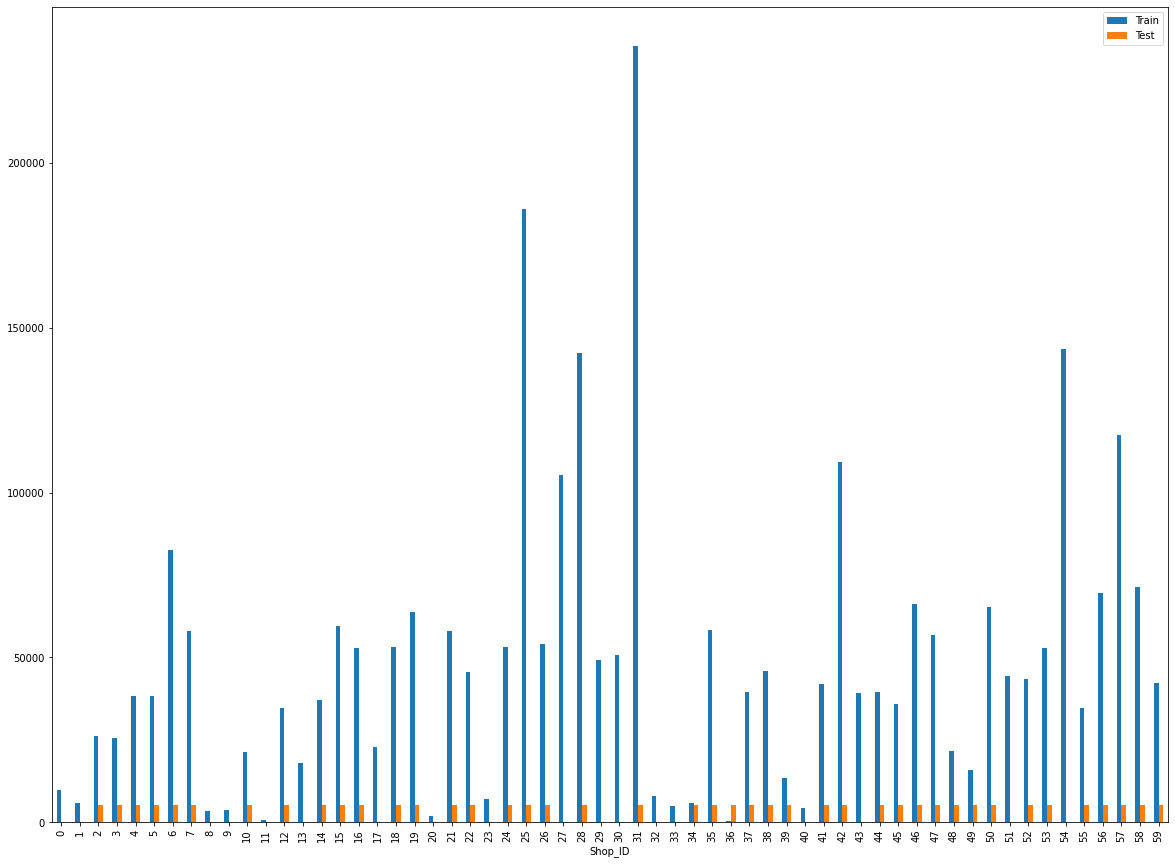

In [ ]:
# We can visualise how much the shops overlap between the two sets 

train_test_shops.plot(x="Shop_ID", y=["Train", "Test"], kind="bar",figsize=(20,15))
plt.show()

It looks like all of the shops in the test set are present in the train set. Let's confirm this:

In [ ]:
print("Number of shops in test set that are not present in train set:", 
      len(train_test_shops[train_test_shops['Train'] == 0]))

Number of shops in test set that are not present in train set: 0


There are too many items to visualise the overlap, so for items we will just create the dataframes and print the results.

In [ ]:
# Repeat for items sold

train_items = sales["item_id"].value_counts()
test_items = test["item_id"].value_counts()

train_test_items = pd.concat([train_items, test_items], axis=1).fillna(0)
train_test_items.reset_index(inplace=True)
train_test_items.columns = ["item_id", "Train", "Test"]

In [ ]:
print("Number of items in test set that are not present in train set:", 
      len(train_test_items[train_test_items['Train'] == 0]))

Number of items in test set that are not present in train set: 363


So  we do have items in the test set that are not present in the train set. This will need to be taken into consideration when producing the model.

In [ ]:
del train_shops
del test_shops
del train_test_shops
del train_items
del test_items
del train_test_items
gc.collect()

13668

Now let us take a look at some of the distributions of the variables in the dataset

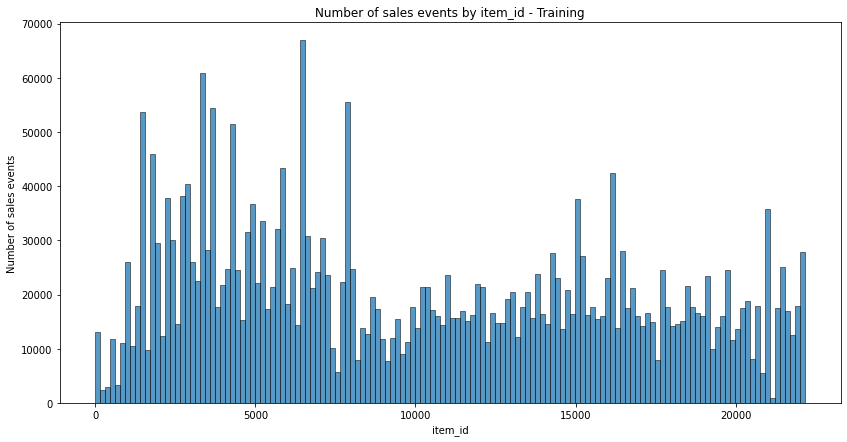

In [ ]:
plt.figure(figsize=(14,7))
sns.histplot(data = sales, x='item_id')
plt.title("Number of sales events by item_id - Training")
plt.ylabel("Number of sales events")
plt.show()

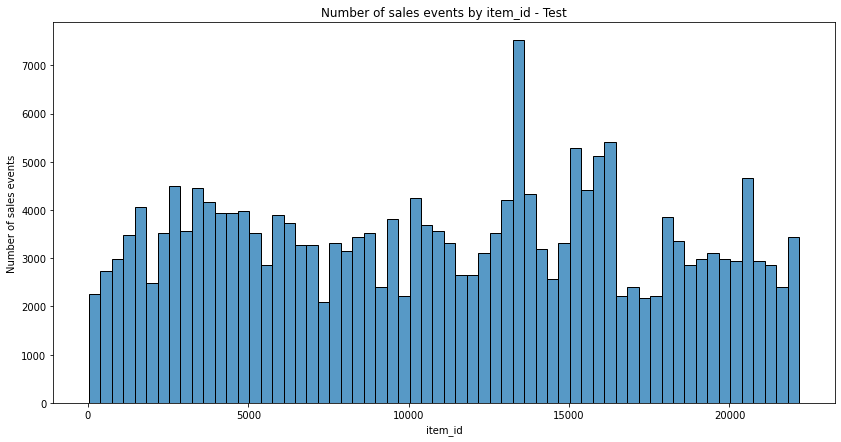

In [ ]:
plt.figure(figsize=(14,7))
sns.histplot(data = test, x='item_id')
plt.title("Number of sales events by item_id - Test")
plt.ylabel("Number of sales events")
plt.show()

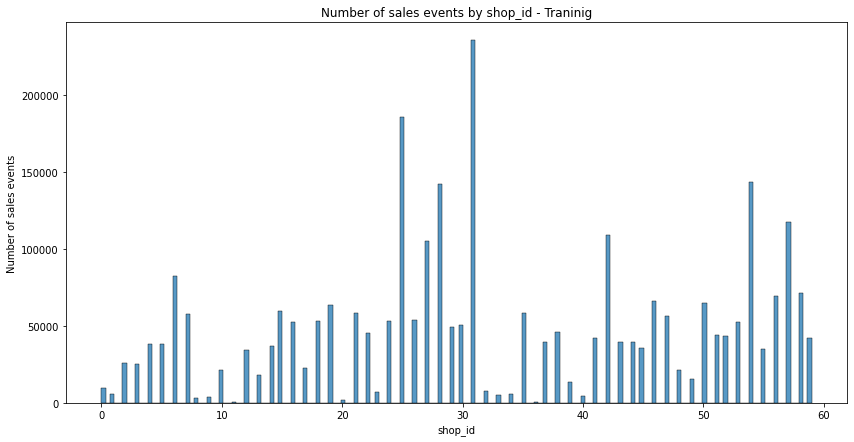

In [ ]:
plt.figure(figsize=(14,7))
sns.histplot(data = sales, x='shop_id')
plt.title("Number of sales events by shop_id - Traninig")
plt.ylabel("Number of sales events")
plt.show()

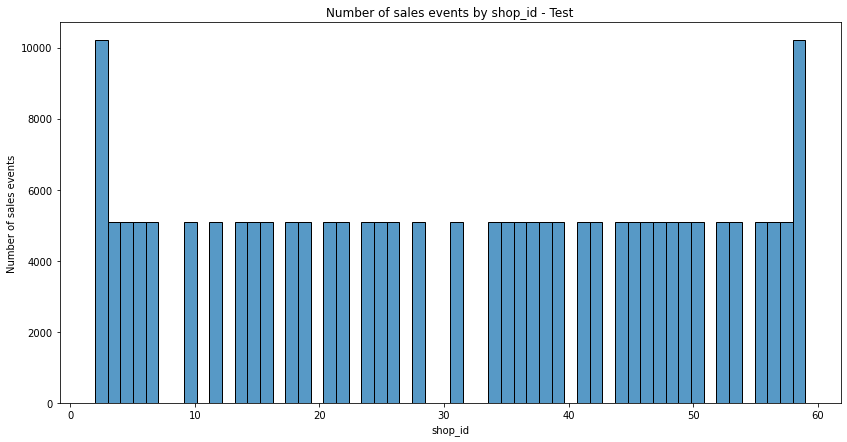

In [ ]:
plt.figure(figsize=(14,7))
sns.histplot(data = test, x='shop_id')
plt.title("Number of sales events by shop_id - Test")
plt.ylabel("Number of sales events")
plt.show()

The number of sales event per item varies quite a lot in the training set. There is less variation in the test set, although one particular item does appear considerably more than all others.

Similarly, the sales events per shop vary in the training set, but are consistent in the test set, with the exception of two shops which appear twice as frequently as the other shops.

We can also look at the total sales by shop (using actual number of items sold rather than counting sales events).

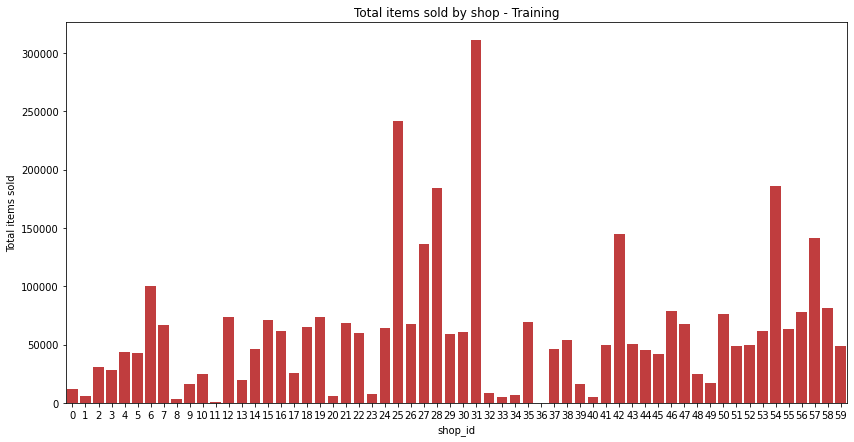

In [ ]:
total_sales_per_shop = pd.DataFrame(sales.groupby("shop_id")["item_cnt_day"].sum())
plt.figure(figsize=(14,7))
sns.barplot(x=total_sales_per_shop.index, y=total_sales_per_shop["item_cnt_day"], color='tab:red')
plt.title("Total items sold by shop - Training")
plt.ylabel("Total items sold")
plt.show()
del total_sales_per_shop
gc.collect();

Next I will look at a plot of sales over time to see if there are any trends.

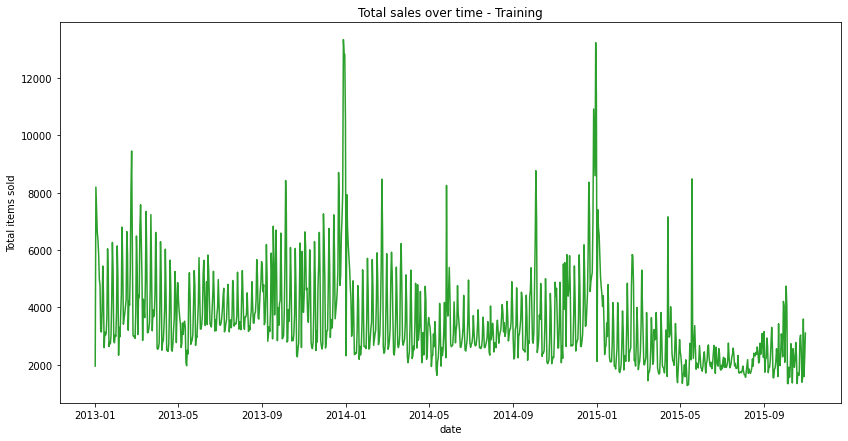

In [ ]:
total_sales_by_day = pd.DataFrame(sales.groupby("date")["item_cnt_day"].sum())
total_sales_by_day.index = pd.to_datetime(total_sales_by_day.index, format='%d.%m.%Y')
plt.figure(figsize=(14,7))
sns.lineplot(data = total_sales_by_day, x="date", y="item_cnt_day", color='tab:green')
plt.title("Total sales over time - Training")
plt.ylabel("Total items sold")
plt.show()

Immediately two peaks jump out. They appear to be around the turn of the year. Let's look closer.

In [ ]:
total_sales_by_day[total_sales_by_day.item_cnt_day>11000]

,item_cnt_day
date,
2013-12-28,13343.0
2013-12-29,12863.0
2013-12-30,12823.0
2014-12-30,13236.0
2014-12-31,11394.0


Indeed, the highest individual days for sales occur in the last few days of December in both 2013 and 2014. These are in fact the days leading up to Russian Orthodox Christmas, which is likely to be a time of high spending. This would explains the peaks.

How does the same plot look but by month?

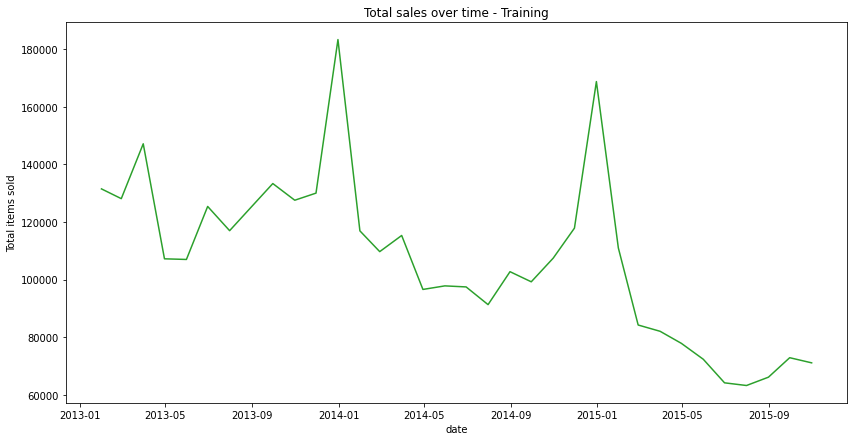

In [ ]:
total_sales_by_month = total_sales_by_day.resample('M').sum()
plt.figure(figsize=(14,7))
sns.lineplot(data = total_sales_by_month, x="date", y="item_cnt_day", color='tab:green')
plt.title("Total sales over time - Training")
plt.ylabel("Total items sold")
plt.show()

From this plot we can see even more clearly that total number of items sold is decreasing over time. Does the same apply for total revenue?

In [ ]:
# We'll make a copy of the sales dataframe to avoid making changes to it. We can delete this copy
# when we're finished with it in order to save memory
total_revenue_by_day = sales.copy(deep=True)
total_revenue_by_day["revenue"] = total_revenue_by_day.item_price*total_revenue_by_day.item_cnt_day
total_revenue_by_day = pd.DataFrame(total_revenue_by_day.groupby('date')['revenue'].sum())
total_revenue_by_day.index = pd.to_datetime(total_revenue_by_day.index, format='%d.%m.%Y')

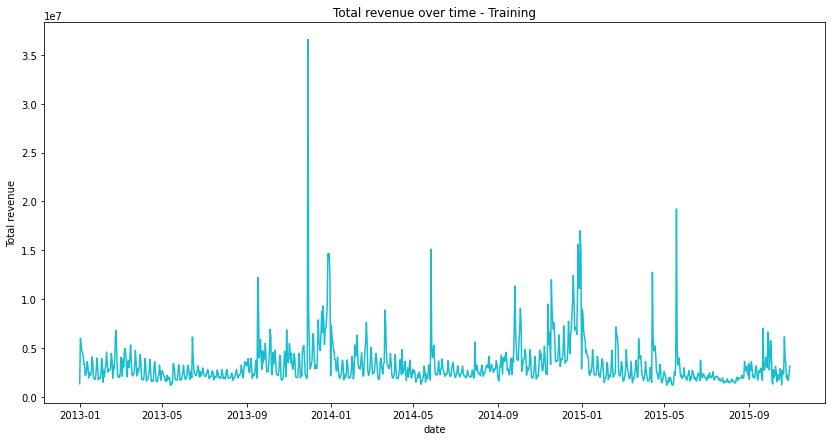

In [ ]:
plt.figure(figsize=(14,7))
sns.lineplot(data = total_revenue_by_day, x="date", y="revenue", color='tab:cyan')
plt.title("Total revenue over time - Training")
plt.ylabel("Total revenue")
plt.show()

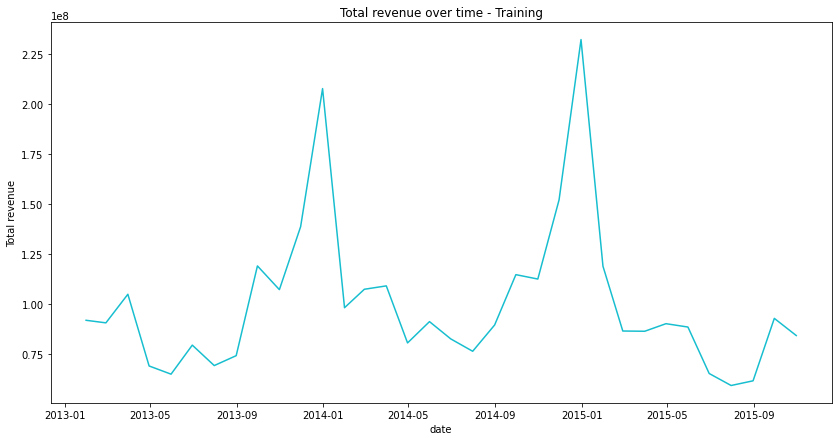

In [ ]:
total_revenue_by_month = total_revenue_by_day.resample('M').sum()
plt.figure(figsize=(14,7))
sns.lineplot(data = total_revenue_by_month, x="date", y="revenue", color='tab:cyan')
plt.title("Total revenue over time - Training")
plt.ylabel("Total revenue")
plt.show()

Interestingly, while numbers of items seems to be decreasing over time, total revenue doesn't seems to reflect this, instead fluctuating somewhere around 1,000,000. Again, we see two large peaks in the monthly graph around the Christmas period. There is also a very large peak in the daily graph which could potentially be an outlier.

In [ ]:
total_revenue_by_day[total_revenue_by_day.revenue>2.5*1e7]

,revenue
date,
2013-11-29,3.654481e+07


In [ ]:
total_revenue_by_day.describe()

,revenue
count,1.034000e+03
mean,3.287163e+06
std,2.257317e+06
min,1.194405e+06
25%,2.095835e+06
50%,2.664234e+06
75%,3.694275e+06
max,3.654481e+07


In [ ]:
iqr = total_revenue_by_day.revenue.quantile(0.75) - total_revenue_by_day.revenue.quantile(0.25)
upper_limit = total_revenue_by_day.revenue.quantile(0.75) + 1.5*iqr
print("Upper limit: {0:,.2f}".format(upper_limit))
print("Maximum revenue: {0:,.2f}".format(total_revenue_by_day.max()[0]))
print("Maximum revenue greater than upper limit: {}".format(total_revenue_by_day.max()[0] > upper_limit))

Upper limit: 6,091,936.32
Maximum revenue: 36,544,808.00
Maximum revenue greater than upper limit: True


As we can see, the peak value is significantly more than 1.5 times the IQR from the upper quartile, so we could consider it to be an outlier. Given though that revenue is a feature that I created from other features, rather than making any adjustments to revenue itself it makes more sense to look for outliers in the other features.

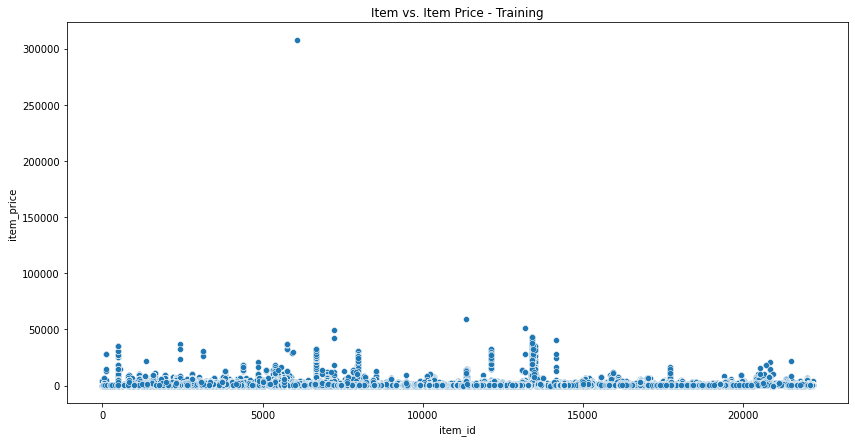

In [ ]:
plt.figure(figsize=(14,7))
sns.scatterplot(x=sales['item_id'], y=sales['item_price'])
plt.title("Item vs. Item Price - Training")
plt.show()

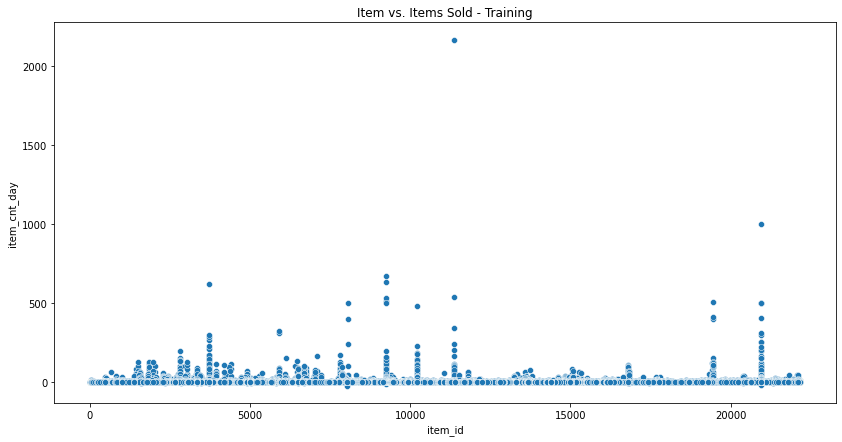

In [ ]:
plt.figure(figsize=(14,7))
sns.scatterplot(x=sales['item_id'], y=sales['item_cnt_day'])
plt.title("Item vs. Items Sold - Training")
plt.show()

In [ ]:
print("Minimum price for any item:", sales["item_price"].min())
print("Maximum price for any item:", sales["item_price"].max())
print("Minimum sales for any item:", sales["item_cnt_day"].min())
print("Maximum sales for any item:", sales["item_cnt_day"].max())

Minimum price for any item: -1.0
Maximum price for any item: 307980.0
Minimum sales for any item: -22.0
Maximum sales for any item: 2169.0


In both the item price and items sold plots we see two clear outliers. We can also see from the print out above that we have negative values for item price and items sold. These likely reflect item returns. However, the competition brief states that the final values are between 0 and 20. Therefore, I do not want negative values in the final results and so I will not use these returns in my modelling.

In [ ]:
sales = sales[(sales.item_price < 300000 )& (sales.item_cnt_day < 1000)]
sales = sales[sales.item_price > 0]
sales.loc[sales.item_cnt_day < 1, "item_cnt_day"] = 0

Another interesting consideration is whether there are more sales on a particular day of the week.

In [ ]:
total_sales_by_day.reset_index(inplace=True)
total_sales_by_day['weekday'] = total_sales_by_day.date.dt.day_name()
total_sales_by_weekday = pd.DataFrame(total_sales_by_day.groupby('weekday')['item_cnt_day'].sum())

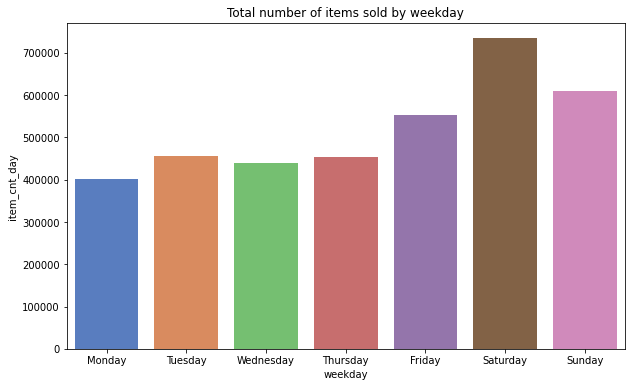

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x=total_sales_by_weekday.index, y = total_sales_by_weekday.item_cnt_day, 
            palette='muted', order=["Monday", "Tuesday", "Wednesday", "Thursday",
                                    "Friday", "Saturday", "Sunday"])
plt.title("Total number of items sold by weekday")
plt.show()

Weekends have the higher number of items sold, especially Saturdays. This could be a useful feature to take into account when it comes to modelling.

In [ ]:
del total_sales_by_day
del total_sales_by_month
del total_sales_by_weekday
del total_revenue_by_day
del total_revenue_by_month
gc.collect()

18074

### Data Preprocessing

I will now move on to the data preprocessing stage, which will include feature engineering.

The first thing to do is to expand our training set. The task is to predict items sold for shop-item pairs. Therefore, we need to make sure that our training data includes every possible item-shop pair (even if the sales for some of these particular combinations is zero).

In [ ]:
items_list = list(sales.item_id.unique())
shops_list = list(sales.shop_id.unique())
dates_list = list(sales.date_block_num.unique())
my_lists = [items_list, shops_list, dates_list]
full_df = pd.DataFrame(list(product(*my_lists)), columns=['item_id', 'shop_id', 'date_block_num'])

In [ ]:
full_df = pd.merge(full_df, sales, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45810963 entries, 0 to 45810962
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   item_id         int64  
 1   shop_id         int64  
 2   date_block_num  int64  
 3   date            object 
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 2.4+ GB


This new dataframe is quite large. To save memory I will downcast the values. I will also drop the date column as it is not needed.

In [ ]:
full_df.item_id = full_df.item_id.astype(np.int16)
full_df.shop_id = full_df.shop_id.astype(np.int16)
full_df.date_block_num = full_df.date_block_num.astype(np.int16)
full_df.item_price = full_df.item_price.astype(np.float32)
full_df.item_cnt_day = full_df.item_cnt_day.astype(np.float32)
full_df.drop('date', axis=1, inplace=True)

In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45810963 entries, 0 to 45810962
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   item_id         int16  
 1   shop_id         int16  
 2   date_block_num  int16  
 3   item_price      float32
 4   item_cnt_day    float32
dtypes: float32(2), int16(3)
memory usage: 961.2 MB


Now I will add a revenue column, before grouping the data together into months rather than days (so that the train data is in the same format as the test data). Once the data is grouped into months, I add a column for both month and year, based on the `date_block_num` column.

In [ ]:
full_df["revenue"] = full_df.item_price*full_df.item_cnt_day

In [ ]:
full_df = pd.DataFrame(full_df.groupby(['date_block_num', 'shop_id', 
                                            'item_id'])[['item_cnt_day', "revenue"]].sum())
full_df.columns = ['item_cnt_month', "revenue"]
full_df.reset_index(inplace=True)

In [ ]:
# Now add month and year
full_df['month'] = 0
full_df['year'] = 0
full_df.month = full_df.date_block_num%12+1
full_df.loc[full_df.date_block_num < 12, "year"] = 2013
full_df.loc[full_df.date_block_num.between(12, 24), "year"] = 2014
full_df.loc[full_df.date_block_num > 23, "year"] = 2015

Before creating any new features, I will join the train and test data. That way, new features will be created for the entire dataset. First I need to get the test set into the same format as the train set. 

Note - when joining train and test sets it is sometimes convenient to add a column indicating whether the data is from the train or test set. This makes it a simple process to split the data again once feature engineering is complete. However, it is not necessary for this dataset, as we already have the `date_block_num` column, and we know that all rows with a value of 34 in this column are from the test set.

In [ ]:
# Add and fill extra columns

test["date_block_num"] = 34
test["item_cnt_month"] = 0
test["revenue"] = 0
test['month'] = 11
test["year"] = 2015

In [ ]:
# Rearrange columns to match train set

test = test[list(full_df.columns)]

In [ ]:
# Join test set to bottom of train set

full_df = pd.concat([full_df, test], ignore_index=True, sort=False)

Now I can move on to the feature engineering.

Given that weekends seem to have more sales than weekdays, I want to add this information to the dataframe. To do so, I will get the weekday for each date in the dataset and then use one-hot encoding to represent this information numerically.

In [ ]:
# First create dataframe of all days in the train and test set

weekdays_df = pd.DataFrame(pd.date_range(start='1/1/2013', end='30/11/2015'), columns=['date'])
weekdays_df["month"] = pd.DatetimeIndex(weekdays_df['date']).month
weekdays_df["year"] = pd.DatetimeIndex(weekdays_df['date']).year
weekdays_df["weekday"] = weekdays_df.date.dt.day_name()

In [ ]:
# Next use one-hot encoding to represent the weekday

oh_encoder = OneHotEncoder(sparse=False)
oh_cols = pd.DataFrame(oh_encoder.fit_transform(weekdays_df[["weekday"]]))
oh_cols.columns = oh_encoder.get_feature_names_out(['weekday'])
oh_cols.index=weekdays_df.index
weekdays_df.drop('weekday', axis=1, inplace=True)
weekdays_df = pd.concat([weekdays_df, oh_cols], axis=1)

In [ ]:
# Get column names to easily rename

weekdays_df.columns

Index(['date', 'month', 'year', 'weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday'],
      dtype='object')

In [ ]:
# Rename columns

weekdays_df.columns = ['date', 'month', 'year', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']

In [ ]:
# Groupby month and year to get counts of each day for each month

weekdays_df = pd.DataFrame(weekdays_df.groupby(['month', 'year'])[['Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']].sum())
weekdays_df.reset_index(inplace=True)

In [ ]:
# Join with full_df

full_df = pd.merge(full_df, weekdays_df, on=['month', 'year'], how='left')

In [ ]:
# Keep the dataframe as small as we can
cols = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
for col in cols:
  full_df[col] = full_df[col].astype(np.int16)

In [ ]:
del weekdays_df
gc.collect()

313

Item category may be a useful feature to add. Not only may the category itself have predictive power, but we can use the category to get an average price for items in each category. This will allow us to have some pricing information for items that are found in the test set but not in the train set.

In [ ]:
full_df = pd.merge(full_df, items, on=['item_id'], how='left')
full_df.drop('item_name', axis=1, inplace=True)
full_df.item_category_id = full_df.item_category_id.astype(np.int16)

I will now create a series of features involving averages. Namely:

*   Average number of sales for each month
*   Average number of sales per item for each month
*   Average number of sales per shop for each month
*   Average number of sales per item category for each month

I will then create lags for each of these new features, on the basis that predicting future sales will rely heavily on past information. Creating lag features enables us to expand the information available in the test set.

In [ ]:
# First, average number of sales of all items per date_block_num

average_sales_total = pd.DataFrame(full_df.groupby(['date_block_num'])['item_cnt_month'].mean())
average_sales_total.columns = ['average_sales_total']
average_sales_total.reset_index(inplace=True)

In [ ]:
# Next, average of each specific item per date_block_num

average_sales_item = pd.DataFrame(full_df.groupby(['date_block_num', 'item_id'])['item_cnt_month'].mean())
average_sales_item.columns = ['average_sales_item']
average_sales_item.reset_index(inplace=True)

In [ ]:
# Now, average of each specific shop per date_block_num

average_sales_shop = pd.DataFrame(full_df.groupby(['date_block_num', 'shop_id'])['item_cnt_month'].mean())
average_sales_shop.columns = ['average_sales_shop']
average_sales_shop.reset_index(inplace=True)

In [ ]:
# Finally, average of each item_category per date_block_num

average_sales_item_cat = pd.DataFrame(full_df.groupby(['date_block_num', 'item_category_id'])['item_cnt_month'].mean())
average_sales_item_cat.columns = ['average_sales_item_category']
average_sales_item_cat.reset_index(inplace=True)

In [ ]:
# Now join the averages to our dataframe, deleting each average dataframe afterwards

average_sales_total.date_block_num +=1
average_sales_total.rename(columns={'average_sales_total':'average_sales_total_lag1'}, inplace=True)
full_df = pd.merge(full_df, average_sales_total, 
                           on = ['date_block_num'], how='left').fillna(0)
average_sales_total.date_block_num +=1
average_sales_total.rename(columns={'average_sales_total_lag1':'average_sales_total_lag2'}, inplace=True)
full_df = pd.merge(full_df, average_sales_total, 
                           on = ['date_block_num'], how='left').fillna(0)
average_sales_total.date_block_num +=1
average_sales_total.rename(columns={'average_sales_total_lag2':'average_sales_total_lag3'}, inplace=True)
full_df = pd.merge(full_df, average_sales_total, 
                           on = ['date_block_num'], how='left').fillna(0)

In [ ]:
del average_sales_total
gc.collect()

200

In [ ]:
average_sales_item.date_block_num +=1
average_sales_item.rename(columns={'average_sales_item':'average_sales_item_lag1'}, inplace=True)
full_df = pd.merge(full_df, average_sales_item, 
                           on = ['date_block_num', 'item_id'], how='left').fillna(0)
average_sales_item.date_block_num +=1
average_sales_item.rename(columns={'average_sales_item_lag1':'average_sales_item_lag2'}, inplace=True)
full_df = pd.merge(full_df, average_sales_item, 
                           on = ['date_block_num', 'item_id'], how='left').fillna(0)
average_sales_item.date_block_num +=1
average_sales_item.rename(columns={'average_sales_item_lag2':'average_sales_item_lag3'}, inplace=True)
full_df = pd.merge(full_df, average_sales_item, 
                           on = ['date_block_num', 'item_id'], how='left').fillna(0)

In [ ]:
del average_sales_item
gc.collect()

100

In [ ]:
average_sales_shop.date_block_num +=1
average_sales_shop.rename(columns={'average_sales_shop':'average_sales_shop_lag1'}, inplace=True)
full_df = pd.merge(full_df, average_sales_shop, 
                           on = ['date_block_num', 'shop_id'], how='left').fillna(0)
average_sales_shop.date_block_num +=1
average_sales_shop.rename(columns={'average_sales_shop_lag1':'average_sales_shop_lag2'}, inplace=True)
full_df = pd.merge(full_df, average_sales_shop, 
                           on = ['date_block_num', 'shop_id'], how='left').fillna(0)
average_sales_shop.date_block_num +=1
average_sales_shop.rename(columns={'average_sales_shop_lag2':'average_sales_shop_lag3'}, inplace=True)
full_df = pd.merge(full_df, average_sales_shop, 
                           on = ['date_block_num', 'shop_id'], how='left').fillna(0)

In [ ]:
del average_sales_shop
gc.collect()

100

In [ ]:
average_sales_item_cat.date_block_num +=1
average_sales_item_cat.rename(columns={'average_sales_item_category':'average_sales_item_category_lag1'}, inplace=True)
full_df = pd.merge(full_df, average_sales_item_cat, 
                           on = ['date_block_num', 'item_category_id'], how='left').fillna(0)
average_sales_item_cat.date_block_num +=1
average_sales_item_cat.rename(columns={'average_sales_item_category_lag1':'average_sales_item_category_lag2'}, inplace=True)
full_df = pd.merge(full_df, average_sales_item_cat, 
                           on = ['date_block_num', 'item_category_id'], how='left').fillna(0)
average_sales_item_cat.date_block_num +=1
average_sales_item_cat.rename(columns={'average_sales_item_category_lag2':'average_sales_item_category_lag3'}, inplace=True)
full_df = pd.merge(full_df, average_sales_item_cat, 
                           on = ['date_block_num', 'item_category_id'], how='left').fillna(0)

In [ ]:
del average_sales_item_cat
gc.collect()

100

Next, I will create lags for the item monthly sales count.

In [ ]:
# Create a function to simplify the process

def create_lags(df, lag):
    temp_df = df.loc[:,['item_id', 'shop_id', 'date_block_num', 'item_cnt_month']]
    temp_df.loc[:, 'date_block_num'] += lag
    return temp_df

In [ ]:
lag_1 = create_lags(full_df, 1)
lag_2 = create_lags(full_df, 2)
lag_3 = create_lags(full_df, 3)

In [ ]:
full_df = pd.merge(full_df, lag_1, 
                           on = ['date_block_num', 'shop_id', 'item_id'], how='left', suffixes=('', '_lag_1')).fillna(0)
full_df = pd.merge(full_df, lag_2, 
                           on = ['date_block_num', 'shop_id', 'item_id'], how='left', suffixes=('', '_lag_2')).fillna(0)
full_df = pd.merge(full_df, lag_3, 
                           on = ['date_block_num', 'shop_id', 'item_id'], how='left', suffixes=('', '_lag_3')).fillna(0)

Some more features that may be useful concern the price of the sold items, specifically:

*   average price of an item over the whole datset
*   average price of an item per item category
*   lags of the average price of an item per month



In [ ]:
item_average_price = pd.DataFrame(sales.groupby(["item_id"])["item_price"].mean())
item_average_price.columns = ["item_average_price"]
item_average_price.reset_index(inplace = True)

In [ ]:
full_df = pd.merge(full_df, item_average_price, on = ['item_id'], how='left').fillna(0)

In [ ]:
sales_with_cats = pd.merge(sales, items, on=['item_id'], how='left')
sales_with_cats.drop('item_name', axis=1, inplace=True)

In [ ]:
item_average_price_cat = pd.DataFrame(sales_with_cats.groupby(["item_category_id"])["item_price"].mean())
item_average_price_cat.columns = ["item_average_price_cat"]
item_average_price_cat.reset_index(inplace = True)

In [ ]:
full_df = pd.merge(full_df, item_average_price_cat, on = ['item_category_id'], how='left').fillna(0)

In [ ]:
item_average_price_monthly = pd.DataFrame(sales.groupby(["date_block_num","item_id"])["item_price"].mean())
item_average_price_monthly.columns = ["item_average_price_monthly"]
item_average_price_monthly.reset_index(inplace = True)

In [ ]:
item_average_price_monthly.date_block_num +=1
item_average_price_monthly.rename(columns={'item_average_price_monthly':'item_average_price_monthly_lag1'}, inplace=True)
full_df = pd.merge(full_df, item_average_price_monthly, 
                           on = ['date_block_num', 'item_id'], how='left').fillna(0)
item_average_price_monthly.date_block_num +=1
item_average_price_monthly.rename(columns={'item_average_price_monthly_lag1':'item_average_price_monthly_lag2'}, inplace=True)
full_df = pd.merge(full_df, item_average_price_monthly, 
                           on = ['date_block_num', 'item_id'], how='left').fillna(0)
item_average_price_monthly.date_block_num +=1
item_average_price_monthly.rename(columns={'item_average_price_monthly_lag2':'item_average_price_monthly_lag3'}, inplace=True)
full_df = pd.merge(full_df, item_average_price_monthly, 
                           on = ['date_block_num', 'item_id'], how='left').fillna(0)

In [ ]:
full_df["average_price_diff_lag1"] = (full_df.item_average_price_monthly_lag1 - full_df.item_average_price) / full_df.item_average_price
full_df["average_price_diff_lag2"] = (full_df.item_average_price_monthly_lag2 - full_df.item_average_price) / full_df.item_average_price
full_df["average_price_diff_lag3"] = (full_df.item_average_price_monthly_lag3 - full_df.item_average_price) / full_df.item_average_price

The final features to add are related to shop revenue, namely the average revenue per shop, as well as lags of the average monthly revenue per shop. 

In [ ]:
average_shop_revenue = pd.DataFrame(full_df.groupby(["shop_id"])["revenue"].mean())
average_shop_revenue.columns = ["average_shop_revenue"]
average_shop_revenue.reset_index(inplace = True)

In [ ]:
full_df = pd.merge(full_df, average_shop_revenue, on = ['shop_id'], how='left').fillna(0)

In [ ]:
shop_average_revenue_monthly = pd.DataFrame(full_df.groupby(["date_block_num","shop_id"])["revenue"].mean())
shop_average_revenue_monthly.columns = ["shop_average_revenue_monthly"]
shop_average_revenue_monthly.reset_index(inplace = True)

In [ ]:
shop_average_revenue_monthly.date_block_num +=1
shop_average_revenue_monthly.rename(columns={'shop_average_revenue_monthly':'shop_average_revenue_monthly_lag1'}, inplace=True)
full_df = pd.merge(full_df, shop_average_revenue_monthly, 
                           on = ['date_block_num', 'shop_id'], how='left').fillna(0)
shop_average_revenue_monthly.date_block_num +=1
shop_average_revenue_monthly.rename(columns={'shop_average_revenue_monthly_lag1':'shop_average_revenue_monthly_lag2'}, inplace=True)
full_df = pd.merge(full_df, shop_average_revenue_monthly, 
                           on = ['date_block_num', 'shop_id'], how='left').fillna(0)
shop_average_revenue_monthly.date_block_num +=1
shop_average_revenue_monthly.rename(columns={'shop_average_revenue_monthly_lag2':'shop_average_revenue_monthly_lag3'}, inplace=True)
full_df = pd.merge(full_df, shop_average_revenue_monthly, 
                           on = ['date_block_num', 'shop_id'], how='left').fillna(0)

In [ ]:
full_df["average_revenue_diff_lag1"] = (full_df.shop_average_revenue_monthly_lag1 - full_df.average_shop_revenue) / full_df.average_shop_revenue
full_df["average_revenue_diff_lag2"] = (full_df.shop_average_revenue_monthly_lag2 - full_df.average_shop_revenue) / full_df.average_shop_revenue
full_df["average_revenue_diff_lag3"] = (full_df.shop_average_revenue_monthly_lag3 - full_df.average_shop_revenue) / full_df.average_shop_revenue

Now that we have the average revenue features, it is important to remember to drop the revenue feature. Naturally we don't know the revenue for the test set, yet we do know it for the training set, including any validation set we create. If I were to retain the revenue column during the modelling process, the model would show great results on the validation set by using this revenue feature, but then would perform poorly on the test set due to the absence of this information.

In [ ]:
full_df.drop('revenue', axis=1, inplace=True)

Because we don't have lag information for the first three months, I will drop all training data for those months.

In [ ]:
full_df = full_df.loc[full_df.date_block_num > 2, :]

Finally, given that the final predictions are in the range 0 to 20, I will clip the train target data to be in this range as well. This will prevent the model from predicting too high (or low) values.

In [ ]:
full_df.item_cnt_month = full_df.item_cnt_month.clip(0, 20)

In [ ]:
full_df.shape

(40773360, 44)

Looking at the shape of the dataframe reveals just how large it is, with over 40 million rows and 44 features. This is why it was essential to use the high-RAM CPU setting on Google Colab Pro +. However, modelling such a dataframe on a CPU would take a long time. Therefore at this stage I will restart the kernel using the GPU setting. 

First though I must save the dataframe. In order to speed up the saving process I will make use of the datatable library.

In [ ]:
full_dt = dt.Frame(full_df)
full_dt.to_csv("/content/drive/MyDrive/Colab Notebooks/final_df.csv")

Restart kernal with GPU

In [ ]:
# Remount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install optuna for hyperparameter optimisation

%pip install optuna

In [ ]:
# Import any necessary libaries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gc
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import optuna

Now I can reload the dataframe from the saved CSV file. I specify datatypes on loading in order to save on memory.

In [ ]:
full_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/final_df.csv",
                      dtype={'date_block_num':np.int8, 'shop_id':np.int8,
                             'item_id':np.int16, 'item_cnt_month':np.int16,
                             'month':np.int8,'year':np.int8, 'Friday':np.int8,
                             'Monday':np.int8, 'Saturday':np.int8,'Sunday':np.int8,
                             'Thursday':np.int8,'Tuesday':np.int8, 'Wednesday':np.int8,
                             'item_category_id':np.int8, 'average_sales_total_lag1':np.float32,
                             'average_sales_total_lag2':np.float32, 'average_sales_total_lag3':np.float32,
                             'average_sales_item_lag1':np.float32, 'average_sales_item_lag2':np.float32,
                             'average_sales_item_lag3':np.float32, 'average_sales_shop_lag1':np.float32,
                             'average_sales_shop_lag2':np.float32, 'average_sales_shop_lag3':np.float32,
                             'average_sales_item_category_lag1':np.float32, 'average_sales_item_category_lag2':np.float32,
                             'average_sales_item_category_lag3':np.float32, 'item_cnt_month_lag_1':np.float32,
                             'item_cnt_month_lag_2':np.float32, 'item_cnt_month_lag_3':np.float32, 'item_average_price':np.float32,
                             'item_average_price_cat':np.float32, 'item_average_price_monthly_lag1':np.float32,
                             'item_average_price_monthly_lag2':np.float32, 'item_average_price_monthly_lag3':np.float32,
                             'average_price_diff_lag1':np.float32, 'average_price_diff_lag2':np.float32,
                             'average_price_diff_lag3':np.float32, 'average_shop_revenue':np.float32,
                             'shop_average_revenue_monthly_lag1':np.float32, 'shop_average_revenue_monthly_lag2':np.float32,
                             'shop_average_revenue_monthly_lag3':np.float32, 'average_revenue_diff_lag1':np.float32,
                             'average_revenue_diff_lag2':np.float32, 'average_revenue_diff_lag3':np.float32})

For the modelling I will use XGBoost Regressor. XGBoost is a very popular Gradient Boosting model which tends to perform very well with regression problems. Despite using Google Colab Pro +, when I initially attempted to create an XGBoost model using the full dataframe, I ran out of memory, causing the kernel to crash. Therefore, without switching platform to a service with higher memory availability, it is going to be necessary to drop some features. 

In order to decide which features to drop, I will use a random sample of 30% of the training set to build an XGBoost model, which I will evaluate against a validation set. Because the overall task involves time-series prediction, it is important to ensure that the validation set reflects the test set. Given that the test set is one month on from the training set, the validation set should be the final month in the training set (rather than using a random sample of data from the training set, as is usually the case in a train-validation split).

After modelling, I will check which features the model found to be the most important. To try to reduce any potential bias in feature selection resulting from the small size of the sample dataset, I will repeat this process four times, taking a random sample each time, and then calculate the average feature importance across all four trials.

In [ ]:
# Create train, test and validation sets.

X_test = full_df[full_df.date_block_num == 34].drop(['item_cnt_month'], axis=1)
train = full_df[full_df.date_block_num < 33]
valid = full_df[full_df.date_block_num == 33]
small_train = train.sample(frac=0.3, replace=False, random_state=1)

In [ ]:
# Create the subsample sets

y_train = small_train['item_cnt_month']
X_train = small_train.drop(['item_cnt_month'], axis=1)
y_valid = valid['item_cnt_month']
X_valid = valid.drop(['item_cnt_month'], axis=1)

In [ ]:
del full_df
gc.collect()

94

In [ ]:
# Define and fit the initial model

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
    verbose=False, 
    early_stopping_rounds = 20)

[14:58:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.8, eta=0.1, max_depth=10, min_child_weight=0.5,
             n_estimators=1000, seed=42, subsample=0.8, tree_method='gpu_hist')

In [ ]:
# Create a dataframe of the feature importance (importance being measured by the weight in this case)

feature_importance = pd.DataFrame.from_dict(model.get_booster().get_score(importance_type='weight'),orient='index')

In [ ]:
# Repeat the process with a new sample

small_train = train.sample(frac=0.30, replace=False, random_state=2)
y_train = small_train['item_cnt_month']
X_train = small_train.drop(['item_cnt_month'], axis=1)
y_valid = valid['item_cnt_month']
X_valid = valid.drop(['item_cnt_month'], axis=1)

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
    verbose=False, 
    early_stopping_rounds = 20)

feature_importance2 = pd.DataFrame.from_dict(model.get_booster().get_score(importance_type='weight'),orient='index')

[14:59:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
small_train = train.sample(frac=0.30, replace=False, random_state=3)
y_train = small_train['item_cnt_month']
X_train = small_train.drop(['item_cnt_month'], axis=1)
y_valid = valid['item_cnt_month']
X_valid = valid.drop(['item_cnt_month'], axis=1)

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
    verbose=False, 
    early_stopping_rounds = 20)

feature_importance3 = pd.DataFrame.from_dict(model.get_booster().get_score(importance_type='weight'),orient='index')

[15:00:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
small_train = train.sample(frac=0.30, replace=False, random_state=3)
y_train = small_train['item_cnt_month']
X_train = small_train.drop(['item_cnt_month'], axis=1)
y_valid = valid['item_cnt_month']
X_valid = valid.drop(['item_cnt_month'], axis=1)

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
    verbose=False, 
    early_stopping_rounds = 20)

feature_importance4 = pd.DataFrame.from_dict(model.get_booster().get_score(importance_type='weight'),orient='index')

[15:01:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Sort the index of each dataframe alphabetically in order to easily join the 
# dataframes. Then sum the different feature importances, before re-sorting the
# dataframe in order of importance

feature_importance.sort_index(inplace=True)
feature_importance2.sort_index(inplace=True)
feature_importance3.sort_index(inplace=True)
feature_importance4.sort_index(inplace=True)
feature_importance_overall = pd.concat([feature_importance, feature_importance2, feature_importance3, feature_importance4], axis=1)
feature_importance_overall['total'] = feature_importance_overall.sum(axis=1)
feature_importance_overall.sort_values(by='total', inplace=True)

In [ ]:
# Get the bottom 18 features (those with the highest feature importance values)

cols_to_use = list(feature_importance_overall.tail(18).index)

In [ ]:
# Check which columns to use

cols_to_use

['average_revenue_diff_lag1',
 'average_sales_item_lag3',
 'month',
 'item_average_price_monthly_lag1',
 'item_cnt_month_lag_3',
 'average_sales_item_category_lag1',
 'item_cnt_month_lag_1',
 'item_average_price',
 'average_price_diff_lag2',
 'date_block_num',
 'item_cnt_month_lag_2',
 'average_sales_shop_lag1',
 'shop_id',
 'average_sales_item_lag2',
 'item_category_id',
 'average_price_diff_lag1',
 'item_id',
 'average_sales_item_lag1']

In [ ]:
# Delete the no longer needed variables

del feature_importance
del feature_importance2
del feature_importance3
del feature_importance4
del feature_importance_overall
del small_train
del train
del valid
del X_test
del X_valid 
del X_train 
del y_train 
del y_valid
del model
gc.collect()

229

Because I deleted the full dataframe before the modelling in order to save memory, I will now reload it. This time though I will load the dataframe with only the columns that the preliminary modelling indicating were the most important (plus, of course, the target column).

In [ ]:
col_types = {'average_revenue_diff_lag1':np.float32, 'average_sales_item_lag3':np.float32,
             'month':np.int8, 'item_average_price_monthly_lag1':np.float32,
             'item_cnt_month_lag_3':np.float32, 'average_sales_item_category_lag1':np.float32,
             'item_cnt_month_lag_1':np.float32, 'item_average_price':np.float32,
             'average_price_diff_lag2':np.float32, 'date_block_num':np.int8,
             'item_cnt_month_lag_2':np.float32, 'average_sales_shop_lag1':np.float32,
             'shop_id':np.int8, 'average_sales_item_lag2':np.float32, 'item_category_id':np.int8,
             'average_price_diff_lag1':np.float32, 'item_id':np.int16,
             'average_sales_item_lag1':np.float32, 'item_cnt_month':np.int16}

In [ ]:
full_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/final_df.csv",
                      usecols = list(col_types.keys()), dtype=col_types)

Now I can recreate the train, test and validation sets, but this time using all rows of the dataframe.

In [ ]:
X_train = full_df[full_df.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = full_df[full_df.date_block_num < 33]['item_cnt_month']
X_valid = full_df[full_df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_valid = full_df[full_df.date_block_num == 33]['item_cnt_month']
X_test = full_df[full_df.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [ ]:
del full_df
gc.collect()

489

XGBoost has a large number of hyperparameters which can have a significant effect on the power of the final model. There are many ways to tune hyperparamters, such as by using one of Scikit-learn's `GridSearchCV` or `RandomizedSearchCV`. However, recently the library `Optuna` has proven very popular for hyperparameter tuning, due mainly to its speed.

I am grateful to Kaggle user Hamza for guidance in using Optuna (see https://www.kaggle.com/hamzaghanmi/xgboost-hyperparameter-tuning-using-optuna).

In [ ]:
# It is first necessary to crate an 'objective' function, which includes the
# hyperparameter options and the model type plus training and validation data

def objective(trial,X_train=X_train, X_valid=X_valid, y_train=y_train, y_valid=y_valid):
    param = {
        'tree_method':'gpu_hist',
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 4000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = XGBRegressor(**param)  
    
    model.fit(X_train,y_train,eval_set=[(X_valid,y_valid)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(X_valid)
    
    rmse = mean_squared_error(y_valid, preds,squared=False)
    
    return rmse

In [ ]:
# We then create a study, instructing it to minimise the specified metric
# (in this case RMSE, as this is the metric used in the competition).
# We can then use the objective function to train the model, testing out
# a specified number of hyperparameter combinations. Here I will test
# 50 different combinations

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-01-29 15:13:40,889] A new study created in memory with name: no-name-722202c3-e4f0-4aee-aa4d-07e312b1ff5b


[15:14:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 15:17:04,431] Trial 0 finished with value: 0.4232562780380249 and parameters: {'lambda': 0.5825428739548669, 'alpha': 6.809959231075246, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 185}. Best is trial 0 with value: 0.4232562780380249.


[15:17:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 15:20:51,355] Trial 1 finished with value: 0.41750216484069824 and parameters: {'lambda': 0.07523578352486561, 'alpha': 0.0015838651191592442, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.009, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 73}. Best is trial 1 with value: 0.41750216484069824.


[15:21:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 15:23:08,132] Trial 2 finished with value: 0.4190121591091156 and parameters: {'lambda': 0.0015329124121221068, 'alpha': 0.260552498445717, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 52}. Best is trial 1 with value: 0.41750216484069824.


[15:23:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 15:29:30,866] Trial 3 finished with value: 0.4147645831108093 and parameters: {'lambda': 0.010204366438338941, 'alpha': 1.1933307419652508, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 29}. Best is trial 3 with value: 0.4147645831108093.


[15:29:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 15:33:23,472] Trial 4 finished with value: 0.4226430058479309 and parameters: {'lambda': 0.7549000314867308, 'alpha': 0.016418512475478632, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 14}. Best is trial 3 with value: 0.4147645831108093.


[15:33:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 15:52:07,862] Trial 5 finished with value: 0.4160682260990143 and parameters: {'lambda': 0.03027430896863157, 'alpha': 0.0109238168673417, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 239}. Best is trial 3 with value: 0.4147645831108093.


[15:52:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 15:58:17,914] Trial 6 finished with value: 0.4142560064792633 and parameters: {'lambda': 0.1844018818859066, 'alpha': 1.553912771815915, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 230}. Best is trial 6 with value: 0.4142560064792633.


[15:58:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 16:00:35,521] Trial 7 finished with value: 0.4185326397418976 and parameters: {'lambda': 0.07728823943679689, 'alpha': 0.01687326143964419, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.018, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 273}. Best is trial 6 with value: 0.4142560064792633.


[16:00:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 16:02:12,266] Trial 8 finished with value: 0.42521047592163086 and parameters: {'lambda': 0.39171722250322355, 'alpha': 0.0057412078834353265, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 4}. Best is trial 6 with value: 0.4142560064792633.


[16:02:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 16:05:36,233] Trial 9 finished with value: 0.4246239960193634 and parameters: {'lambda': 0.042176057225047414, 'alpha': 0.03976217419167906, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 54}. Best is trial 6 with value: 0.4142560064792633.


[16:05:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 16:14:30,954] Trial 10 finished with value: 0.41412919759750366 and parameters: {'lambda': 8.142113194582342, 'alpha': 9.656576784091508, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 140}. Best is trial 10 with value: 0.41412919759750366.


[16:14:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 16:23:15,518] Trial 11 finished with value: 0.41422808170318604 and parameters: {'lambda': 3.595968658016194, 'alpha': 6.573337912670826, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 134}. Best is trial 10 with value: 0.41412919759750366.


[16:23:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 16:32:14,217] Trial 12 finished with value: 0.4142787754535675 and parameters: {'lambda': 7.497057914736641, 'alpha': 9.102342692868595, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 125}. Best is trial 10 with value: 0.41412919759750366.


[16:32:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 16:34:20,413] Trial 13 finished with value: 0.4193084239959717 and parameters: {'lambda': 9.32892167078238, 'alpha': 1.2037857290217093, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 144}. Best is trial 10 with value: 0.41412919759750366.


[16:34:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 16:39:54,786] Trial 14 finished with value: 0.415653795003891 and parameters: {'lambda': 2.6827281383923274, 'alpha': 3.4837688202498187, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 179}. Best is trial 10 with value: 0.41412919759750366.


[16:40:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 16:44:22,113] Trial 15 finished with value: 0.41765880584716797 and parameters: {'lambda': 1.56975341236165, 'alpha': 0.2513484209088359, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 105}. Best is trial 10 with value: 0.41412919759750366.


[16:44:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 16:46:39,758] Trial 16 finished with value: 0.42023608088493347 and parameters: {'lambda': 2.934084583099028, 'alpha': 0.33239595319794085, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 98}. Best is trial 10 with value: 0.41412919759750366.


[16:47:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 17:01:38,654] Trial 17 finished with value: 0.4138675332069397 and parameters: {'lambda': 4.123736367900577, 'alpha': 2.9286907683467116, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 178}. Best is trial 17 with value: 0.4138675332069397.


[17:01:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 17:15:25,208] Trial 18 finished with value: 0.41428399085998535 and parameters: {'lambda': 1.0735239596984543, 'alpha': 2.469996043780592, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 206}. Best is trial 17 with value: 0.4138675332069397.


[17:15:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 17:21:06,937] Trial 19 finished with value: 0.41709664463996887 and parameters: {'lambda': 0.23473855930254034, 'alpha': 0.49952232037995925, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 174}. Best is trial 17 with value: 0.4138675332069397.


[17:21:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 17:33:25,851] Trial 20 finished with value: 0.41593459248542786 and parameters: {'lambda': 5.452027036070992, 'alpha': 0.07041617224992637, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.009, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 296}. Best is trial 17 with value: 0.4138675332069397.


[17:33:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 17:47:29,422] Trial 21 finished with value: 0.4141160845756531 and parameters: {'lambda': 3.239410286158547, 'alpha': 4.781896215269346, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 155}. Best is trial 17 with value: 0.4138675332069397.


[17:47:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 18:01:10,725] Trial 22 finished with value: 0.41410425305366516 and parameters: {'lambda': 1.5289061668090242, 'alpha': 3.5699885636638196, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 161}. Best is trial 17 with value: 0.4138675332069397.


[18:01:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 18:14:41,908] Trial 23 finished with value: 0.41418349742889404 and parameters: {'lambda': 2.01920368593913, 'alpha': 0.6546646244578684, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 162}. Best is trial 17 with value: 0.4138675332069397.


[18:15:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 18:19:30,762] Trial 24 finished with value: 0.4149360954761505 and parameters: {'lambda': 1.2333825275529433, 'alpha': 2.8669175681269494, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 218}. Best is trial 17 with value: 0.4138675332069397.


[18:19:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 18:22:09,130] Trial 25 finished with value: 0.41905084252357483 and parameters: {'lambda': 0.32842086921001307, 'alpha': 4.530991858462818, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 197}. Best is trial 17 with value: 0.4138675332069397.


[18:22:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 18:24:51,065] Trial 26 finished with value: 0.4212825894355774 and parameters: {'lambda': 3.930691912247118, 'alpha': 0.15365197856365942, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 102}. Best is trial 17 with value: 0.4138675332069397.


[18:25:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 18:34:55,636] Trial 27 finished with value: 0.4142528176307678 and parameters: {'lambda': 0.7922744747764285, 'alpha': 0.9498536701815361, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 156}. Best is trial 17 with value: 0.4138675332069397.


[18:35:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 18:50:33,727] Trial 28 finished with value: 0.41362813115119934 and parameters: {'lambda': 1.720706479714062, 'alpha': 2.2535278490963906, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 116}. Best is trial 28 with value: 0.41362813115119934.


[18:50:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 19:06:02,206] Trial 29 finished with value: 0.41370972990989685 and parameters: {'lambda': 0.44201516407256847, 'alpha': 2.466945685533745, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 120}. Best is trial 28 with value: 0.41362813115119934.


[19:06:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 19:39:41,151] Trial 30 finished with value: 0.4154784679412842 and parameters: {'lambda': 0.481177372501951, 'alpha': 1.8881578937362216, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 76}. Best is trial 28 with value: 0.41362813115119934.


[19:40:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 19:55:18,824] Trial 31 finished with value: 0.4136158227920532 and parameters: {'lambda': 0.15673719864782545, 'alpha': 0.6692403507379175, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 116}. Best is trial 31 with value: 0.4136158227920532.


[19:55:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 20:09:01,171] Trial 32 finished with value: 0.4156424403190613 and parameters: {'lambda': 0.13295572855081653, 'alpha': 0.6388961756644777, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 118}. Best is trial 31 with value: 0.4136158227920532.


[20:09:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 20:27:06,740] Trial 33 finished with value: 0.41390371322631836 and parameters: {'lambda': 0.010346199825349234, 'alpha': 2.034079942618647, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 69}. Best is trial 31 with value: 0.4136158227920532.


[20:27:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 20:34:40,150] Trial 34 finished with value: 0.41513240337371826 and parameters: {'lambda': 0.5538319338767682, 'alpha': 0.9357010600639135, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 83}. Best is trial 31 with value: 0.4136158227920532.


[20:35:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 20:39:37,342] Trial 35 finished with value: 0.4167308211326599 and parameters: {'lambda': 0.0015215995312536138, 'alpha': 0.0018820206840871655, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 118}. Best is trial 31 with value: 0.4136158227920532.


[20:39:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 20:42:39,887] Trial 36 finished with value: 0.4219362735748291 and parameters: {'lambda': 0.04892933488045571, 'alpha': 0.45595310448819604, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 92}. Best is trial 31 with value: 0.4136158227920532.


[20:43:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 20:59:27,351] Trial 37 finished with value: 0.4177919924259186 and parameters: {'lambda': 0.016026660866157543, 'alpha': 0.10131628662740623, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 36}. Best is trial 31 with value: 0.4136158227920532.


[20:59:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 21:02:48,266] Trial 38 finished with value: 0.41820028424263 and parameters: {'lambda': 0.12196440687594566, 'alpha': 1.659050521946327, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 194}. Best is trial 31 with value: 0.4136158227920532.


[21:03:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 21:06:47,694] Trial 39 finished with value: 0.4164930582046509 and parameters: {'lambda': 0.1979501809805144, 'alpha': 6.026450050816362, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 256}. Best is trial 31 with value: 0.4136158227920532.


[21:07:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 21:17:03,500] Trial 40 finished with value: 0.4204915761947632 and parameters: {'lambda': 0.6184935883214656, 'alpha': 0.23229718744984434, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 61}. Best is trial 31 with value: 0.4136158227920532.


[21:17:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 21:38:40,293] Trial 41 finished with value: 0.41353756189346313 and parameters: {'lambda': 0.0030685237970530825, 'alpha': 2.4345367906765505, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 38}. Best is trial 41 with value: 0.41353756189346313.


[21:39:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 22:01:27,633] Trial 42 finished with value: 0.4135960340499878 and parameters: {'lambda': 0.019410573448397864, 'alpha': 1.1115932695543924, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 31}. Best is trial 41 with value: 0.41353756189346313.


[22:01:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 22:38:28,968] Trial 43 finished with value: 0.41519102454185486 and parameters: {'lambda': 0.0040933783269672865, 'alpha': 1.2873875922970253, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 46}. Best is trial 41 with value: 0.41353756189346313.


[22:38:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 22:41:28,627] Trial 44 finished with value: 0.42467084527015686 and parameters: {'lambda': 0.0023475803494392446, 'alpha': 0.7863800112565207, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 25}. Best is trial 41 with value: 0.41353756189346313.


[22:41:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 23:09:38,864] Trial 45 finished with value: 0.41420096158981323 and parameters: {'lambda': 0.005164405132965657, 'alpha': 1.5910132847976248, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 15}. Best is trial 41 with value: 0.41353756189346313.


[23:10:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 23:12:51,363] Trial 46 finished with value: 0.41666096448898315 and parameters: {'lambda': 0.027586082088427187, 'alpha': 0.436837801313179, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 43}. Best is trial 41 with value: 0.41353756189346313.


[23:13:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 23:31:34,148] Trial 47 finished with value: 0.4138278365135193 and parameters: {'lambda': 0.001064755758466033, 'alpha': 6.768173396500736, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 60}. Best is trial 41 with value: 0.41353756189346313.


[23:31:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 23:54:42,809] Trial 48 finished with value: 0.42217695713043213 and parameters: {'lambda': 0.07730409036843267, 'alpha': 1.1779053158838153, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 7}. Best is trial 41 with value: 0.41353756189346313.


[23:55:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-01-29 23:59:35,723] Trial 49 finished with value: 0.41399943828582764 and parameters: {'lambda': 0.019973363690420666, 'alpha': 4.30759157447084, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.016, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 127}. Best is trial 41 with value: 0.41353756189346313.


Number of finished trials: 50
Best trial: {'lambda': 0.0030685237970530825, 'alpha': 2.4345367906765505, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 38}


Now that the hyperparameter search is complete, Optuna has a number of handy methods to allow us to visualise the results

In [ ]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_lambda,params_learning_rate,params_max_depth,params_min_child_weight,params_random_state,params_subsample,state
0,0,0.423256,2022-01-29 15:13:40.891947,2022-01-29 15:17:04.431110,0 days 00:03:23.539163,6.809959,0.8,0.582543,0.018,5,185,24,1.0,COMPLETE
1,1,0.417502,2022-01-29 15:17:04.433561,2022-01-29 15:20:51.354605,0 days 00:03:46.921044,0.001584,0.8,0.075236,0.009,11,73,48,0.4,COMPLETE
2,2,0.419012,2022-01-29 15:20:51.356711,2022-01-29 15:23:08.132306,0 days 00:02:16.775595,0.260552,1.0,0.001533,0.018,11,52,48,1.0,COMPLETE
3,3,0.414765,2022-01-29 15:23:08.134911,2022-01-29 15:29:30.865610,0 days 00:06:22.730699,1.193331,0.7,0.010204,0.012,15,29,2020,1.0,COMPLETE
4,4,0.422643,2022-01-29 15:29:30.867766,2022-01-29 15:33:23.471446,0 days 00:03:52.603680,0.016419,0.3,0.754900,0.008,5,14,24,0.4,COMPLETE
5,5,0.416068,2022-01-29 15:33:23.473869,2022-01-29 15:52:07.861945,0 days 00:18:44.388076,0.010924,0.3,0.030274,0.014,20,239,48,0.7,COMPLETE
6,6,0.414256,2022-01-29 15:52:07.864341,2022-01-29 15:58:17.913537,0 days 00:06:10.049196,1.553913,0.5,0.184402,0.020,20,230,48,0.4,COMPLETE
7,7,0.418533,2022-01-29 15:58:17.916038,2022-01-29 16:00:35.521010,0 days 00:02:17.604972,0.016873,1.0,0.077288,0.018,11,273,24,0.4,COMPLETE
8,8,0.425210,2022-01-29 16:00:35.523370,2022-01-29 16:02:12.265619,0 days 00:01:36.742249,0.005741,0.8,0.391717,0.016,5,4,48,0.4,COMPLETE
9,9,0.424624,2022-01-29 16:02:12.268737,2022-01-29 16:05:36.232590,0 days 00:03:23.963853,0.039762,1.0,0.042176,0.014,5,54,24,0.5,COMPLETE


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_contour(study, params=['alpha',
                            'max_depth',
                            'lambda',
                            'subsample',
                            'learning_rate',
                            'subsample'])

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_edf(study)

Perhaps the most informative visualisation is the second to last plot, which tells us which hyerparameter is most important when it comes to improving the model. As we can see, the max depth of the trees is by far the most important parameter for our model.

Now that I have the best combination of hyperparameters, I can move on to the final modelling stage. I will use 5,000 estimators, but include an early stopping round of 50 in order to avoid overfitting.

In [ ]:
model = XGBRegressor(
    reg_lambda=0.0030685237970530825,
    reg_alpha = 2.4345367906765505,
    colsample_bytree = 0.5,
    subsample = 0.5,
    learning_rate = 0.008,
    max_depth = 20,
    min_child_weight = 38,
    tree_method='gpu_hist',
    n_estimators=5000)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 50)

[07:42:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.742891	validation_1-rmse:0.6678
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.739267	validation_1-rmse:0.664588
[2]	validation_0-rmse:0.735717	validation_1-rmse:0.661456
[3]	validation_0-rmse:0.732134	validation_1-rmse:0.658238
[4]	validation_0-rmse:0.728539	validation_1-rmse:0.655164
[5]	validation_0-rmse:0.725266	validation_1-rmse:0.652349
[6]	validation_0-rmse:0.721639	validation_1-rmse:0.649227
[7]	validation_0-rmse:0.718462	validation_1-rmse:0.646398
[8]	validation_0-rmse:0.715038	validation_1-rmse:0.643377
[9]	validation_0-rmse:0.711605	validation_1-rmse:0.640512
[10]	validation_0-rmse:0.708485	validation_1-rmse:0.6377
[11]	validation_0-rmse:0.705263	validation_1-rmse:0.634847
[12]	validation_0-rm

XGBRegressor(colsample_bytree=0.5, learning_rate=0.008, max_depth=20,
             min_child_weight=38, n_estimators=5000,
             reg_alpha=2.4345367906765505, reg_lambda=0.0030685237970530825,
             subsample=0.5, tree_method='gpu_hist')

I can now use the model to create final predictions for the competition. It is important to remember to clip the final predictions into the specified range.

I will also check the feature importance to see which features were most important to the final model.

In [ ]:
preds = model.predict(X_test).clip(0,20)
submission_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_submission.csv')
submission_df['item_cnt_month'] = preds
submission_df.to_csv("/content/drive/MyDrive/Colab Notebooks/tuned_XGB2.csv", index=False)

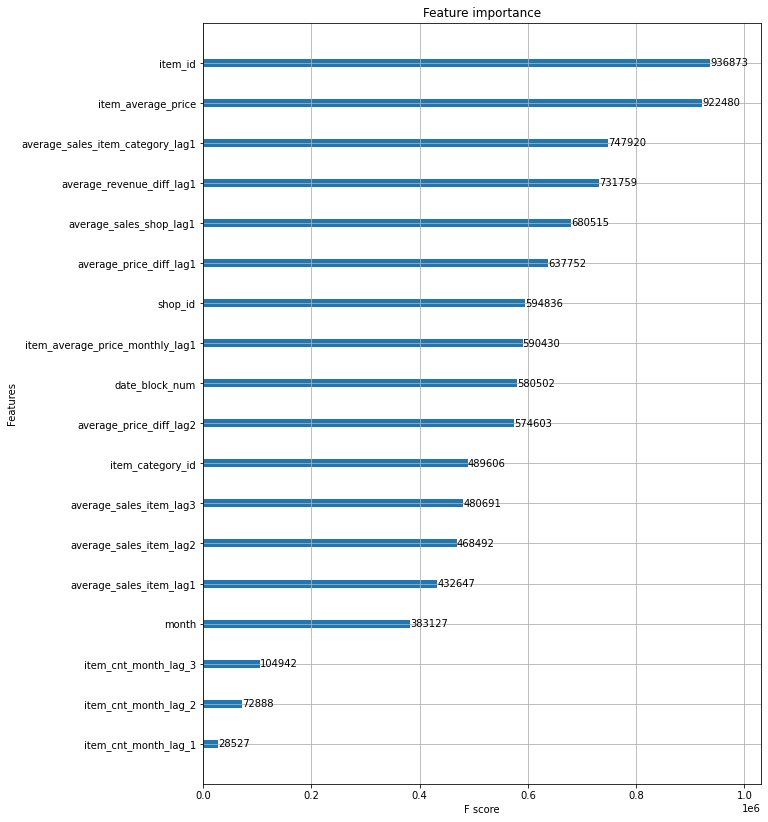

In [ ]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))
plt.show()

The submission achieved a score of 0.98901 on the public leaderboard. This is an improvement on the suggested benchmark model (not included in this notebook) which simply used October's sales as a prediction for November. The benchmark model had an RMSE of 1.16777. 

However, there is still room for improvement. The top score on the leaderboard at the time of writing is 0.75368. One potential way to improve my score would be to make use of the text information from the shops and item categories features that I dropped early on. Another possible approach would be to use an LSTM autoencoder, a model which is very popular for time series predictions.